In [24]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))

In [25]:
source('main.R')

data <- kaggle.house$loadData() 

df.combined <- 
    kaggle.house$getCombinedDataset(data$train, data$test) %>%
    (kaggle.house$na$fixAll) %>%
    (kaggle.house$outliers$removeOutliers) %>%
    rename(price = SalePrice) %>%
    mutate(
        log.price = log(price),
        sq.feat.price = price / GrLivArea
    )  

combine.levels.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 1,
            OverallQual %in% c(9, 10) ~ 6,
            TRUE ~ OverallQual - 3
        )
    )
}

trainset <- 
    df.combined %>% 
    filter(dataSource == "train") %>%
    select(-dataSource) %>%
    (combine.levels.OverallQual) %>%
    mutate(
        log.area = log(GrLivArea)
    )

trainset %>% nrow

trainset.cat <- trainset %>% 
    select(one_of(union(kaggle.house$getCategoricalColumnNames(.), 
                        c("price", "log.price", "sq.feat.price"))))

trainset.num <-  trainset %>% select_if(is.numeric)

trainset.cat %>% colnames
trainset.num %>% colnames

[1] 1458

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MSSubClass"    "MSZoning"      "Neighborhood" 
[37] "PavedDrive"    "PoolQC"        "RoofMatl"      "RoofStyle"    
[41] "SaleCondition" "SaleType"      "Street"        "Utilities"    
[45] "price"         "log.price"     "sq.feat.price"

[1] "LotFrontage"   "LotArea"       "OverallQual"   "OverallCond"  
 [5] "YearBuilt"     "YearRemodAdd"  "MasVnrArea"    "BsmtFinSF1"   
 [9] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "X1stFlrSF"    
[13] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[17] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[21] "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"    "GarageYrBlt"  
[25] "GarageCars"    "GarageArea"    "WoodDeckSF"    "OpenPorchSF"  
[29] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[33] "MiscVal"       "MoSold"        "YrSold"        "price"        
[37] "log.price"     "sq.feat.price" "quality"       "log.area"

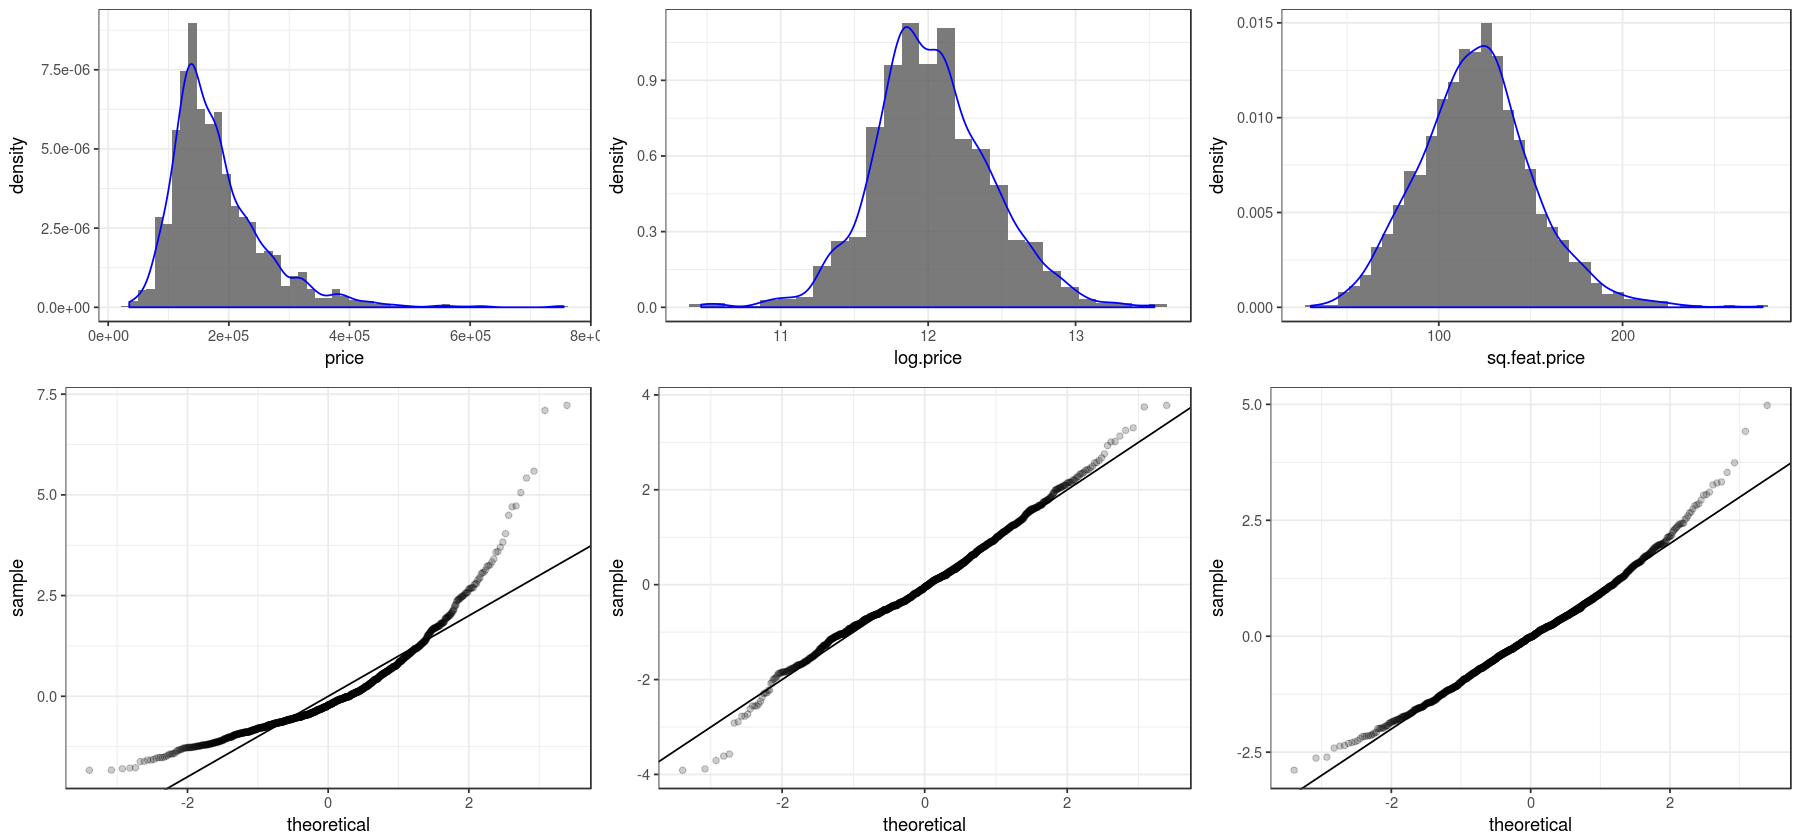

In [26]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(log.price)) +
    geom_histogram(aes(y=..density..), binwidth=0.12, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p3 <- trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        log.price.norm = (log.price - mean(log.price)) / sd(log.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=log.price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

x <- grid.arrange(p1, p2, p3, qq1, qq2, qq3, 
                  layout_matrix=rbind(c(1, 2, 3), 
                                      c(4, 5, 6)),
                 heights=c(45, 55))

In [27]:
log.price.vs.cat <- 
    trainset.cat %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

log.price.vs.cat %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,FireplaceQu,Foundation,GarageType,MSSubClass,BsmtFinType1
r2,0.546,0.486,0.470,0.462,0.307,0.295,0.257,0.250,0.247,0.212
r2.log,0.572,0.466,0.455,0.451,0.382,0.311,0.304,0.335,0.331,0.228
r2.sq.feat,0.388,0.256,0.307,0.249,0.183,0.068,0.203,0.158,0.367,0.243


var.name,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,GarageType,MSSubClass,FireplaceQu,Foundation,HeatingQC
r2,0.546,0.486,0.470,0.462,0.307,0.250,0.247,0.295,0.257,0.196
r2.log,0.572,0.466,0.455,0.451,0.382,0.335,0.331,0.311,0.304,0.234
r2.sq.feat,0.388,0.256,0.307,0.249,0.183,0.158,0.367,0.068,0.203,0.140


var.name,Neighborhood,MSSubClass,BsmtQual,ExterQual,KitchenQual,BsmtFinType1,HouseStyle,Foundation,BsmtExposure,GarageFinish
r2,0.546,0.247,0.470,0.486,0.462,0.212,0.087,0.257,0.151,0.307
r2.log,0.572,0.331,0.455,0.466,0.451,0.228,0.102,0.304,0.143,0.382
r2.sq.feat,0.388,0.367,0.307,0.256,0.249,0.243,0.234,0.203,0.193,0.183


In [28]:
log.price.vs.num <- 
    trainset.num %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

log.price.vs.num %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,OverallQual,quality,GrLivArea,log.area,TotalBsmtSF,GarageCars,X1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd
r2,0.633,0.621,0.540,0.494,0.424,0.411,0.399,0.396,0.316,0.289
r2.log,0.675,0.657,0.526,0.544,0.419,0.464,0.385,0.431,0.355,0.289
r2.sq.feat,0.240,0.234,0.007,0.011,0.229,0.166,0.093,0.170,0.009,0.031


var.name,OverallQual,quality,log.area,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,YearBuilt
r2,0.633,0.621,0.494,0.540,0.411,0.396,0.424,0.399,0.316,0.274
r2.log,0.675,0.657,0.544,0.526,0.464,0.431,0.419,0.385,0.355,0.345
r2.sq.feat,0.240,0.234,0.011,0.007,0.166,0.170,0.229,0.093,0.009,0.317


var.name,YearBuilt,OverallQual,quality,TotalBsmtSF,YearRemodAdd,BsmtFinSF1,GarageArea,GarageCars,BedroomAbvGr,BsmtFullBath
r2,0.274,0.633,0.621,0.424,0.258,0.168,0.396,0.411,0.028,0.052
r2.log,0.345,0.675,0.657,0.419,0.320,0.154,0.431,0.464,0.044,0.056
r2.sq.feat,0.317,0.240,0.234,0.229,0.208,0.201,0.170,0.166,0.128,0.125


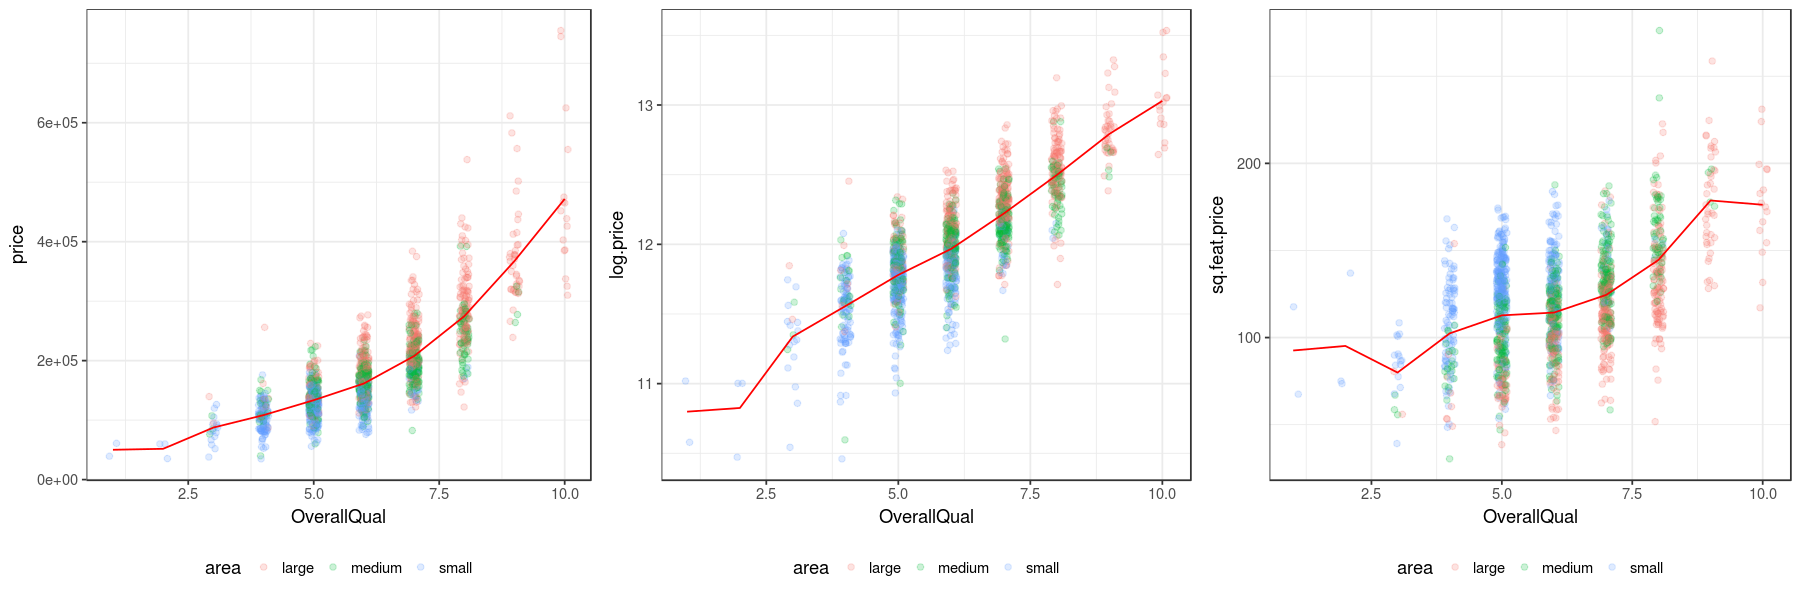

In [29]:
df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

p1 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=log.price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    df %>%
    ggplot(aes(x=OverallQual, y=sq.feat.price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

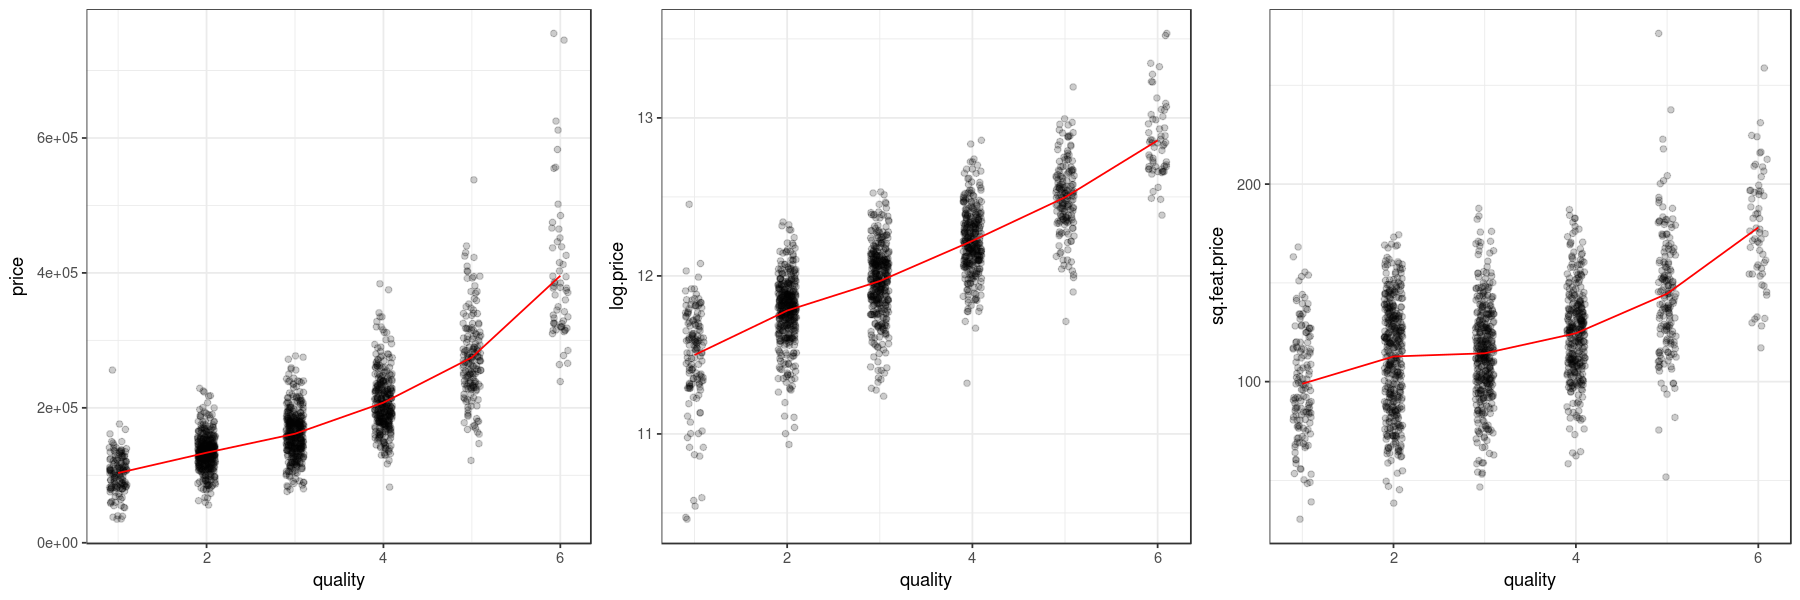

In [30]:
p1 <- 
    trainset %>%
    ggplot(aes(x=quality, y=price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    trainset %>%
    ggplot(aes(x=quality, y=log.price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    trainset %>%
    ggplot(aes(x=quality, y=sq.feat.price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

In [31]:
trainset.num %>% 
    select(-OverallQual, -price, -log.price, -sq.feat.price) %>% 
    cor(trainset.num$OverallQual) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr=V1) %>%
    left_join(log.price.vs.num, by='var.name') %>%
    mutate(`r2.log/corr` = r2.log/corr) %>%
    arrange(desc(abs(`r2.log/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    head(10)

var.name,corr,r2,r2.log,r2.sq.feat,r2.log/corr
log.area,0.609,0.494,0.544,0.011,0.893
GrLivArea,0.589,0.540,0.526,0.007,0.892
X1stFlrSF,0.469,0.399,0.385,0.093,0.821
TotalBsmtSF,0.539,0.424,0.419,0.229,0.778
GarageArea,0.557,0.396,0.431,0.170,0.773
GarageCars,0.601,0.411,0.464,0.166,0.772
LotArea,0.091,0.072,0.068,0.013,0.744
BsmtFinSF1,0.222,0.168,0.154,0.201,0.692
TotRmsAbvGrd,0.421,0.289,0.289,0.031,0.687
quality,0.989,0.621,0.657,0.234,0.664


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.525931,0.5256054,0.2753092,1615.283,2.966447e-238,2,-187.1954,380.3908,396.2453,110.3578,1456


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5437991,0.5434858,0.2700711,1735.576,2.079661e-250,2,-159.1875,324.3749,340.2294,106.1983,1456


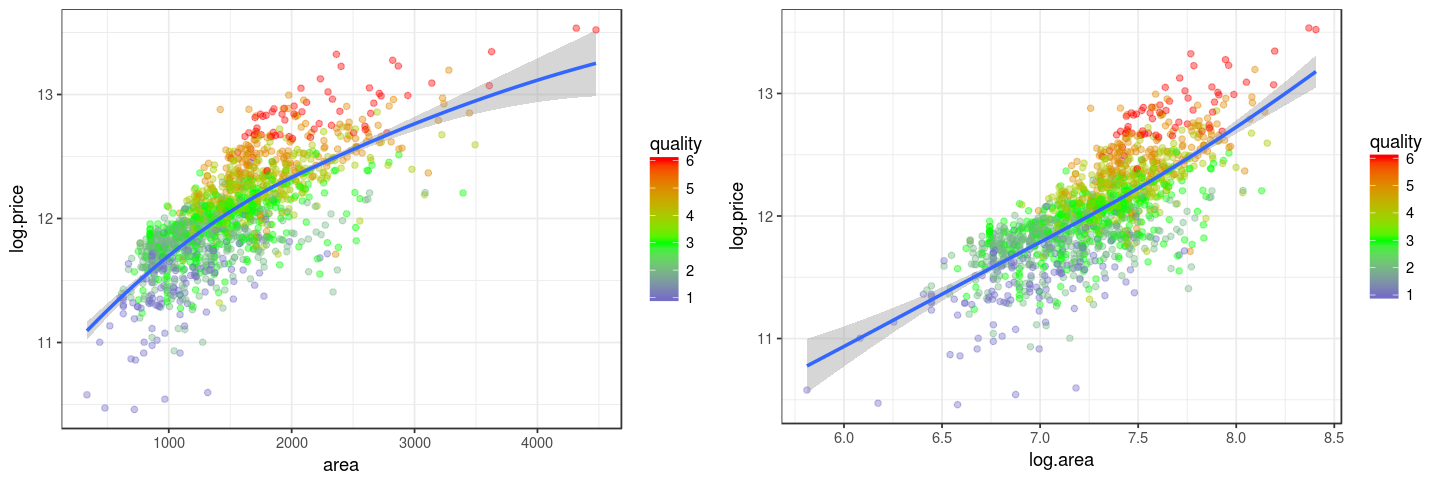

In [34]:
p1 <- 
    trainset %>% rename(area=GrLivArea) %>%
    ggplot(aes(x=area, y=log.price)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <- 
    trainset %>%
    ggplot(aes(x=log.area, y=log.price)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

lm(log.price ~ GrLivArea, data=df) %>% glance
lm(log.price ~ log.area, data=df) %>% glance

options(repr.plot.width = 12, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

In [10]:
trainset.num %>%
    select(-GrLivArea, -OverallQual, -quality, -price, -log.price, -sq.feat.price) %>%
    select(-log.area) %>%
    cor(df$log.area) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr=V1) %>%
    left_join(log.price.vs.num, by='var.name') %>%
    mutate(`r2.log/corr` = r2.log/corr) %>%
    filter(r2.log > 0.1) %>% 
    arrange(desc(abs(`r2.log/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3)))

var.name,corr,r2,r2.log,r2.sq.feat,r2.log/corr
YearBuilt,0.232,0.274,0.345,0.317,1.488
BsmtFinSF1,0.130,0.168,0.154,0.201,1.185
YearRemodAdd,0.309,0.258,0.320,0.208,1.036
TotalBsmtSF,0.419,0.424,0.419,0.229,1.001
GarageCars,0.497,0.411,0.464,0.166,0.934
GarageArea,0.467,0.396,0.431,0.170,0.922
X1stFlrSF,0.539,0.399,0.385,0.093,0.714
GarageYrBlt,0.208,0.068,0.122,0.054,0.586
FullBath,0.653,0.316,0.355,0.009,0.544
MasVnrArea,0.348,0.228,0.185,0.052,0.532


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.6600165,0.6595491,0.2332266,1412.309,0,3,55.16486,-102.3297,-81.19043,79.14423,1455


term,estimate,std.error,statistic,p.value
(Intercept),11.3630041,0.033215016,342.104430,0.000000e+00
quality,0.1682582,0.021580926,7.796615,1.203635e-14
q2,0.0122278,0.003193405,3.829078,1.340868e-04


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.5437991,0.5434858,0.2700711,1735.576,2.079661e-250,2,-159.1875,324.3749,340.2294,106.1983,1456


term,estimate,std.error,statistic,p.value
(Intercept),5.5415392,0.15576391,35.57653,5.072263e-200
log.area,0.8921619,0.02141518,41.66025,2.079661e-250


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.754635,0.7542977,0.1981324,2237.47,0,3,292.9283,-577.8566,-556.7173,57.11814,1455


term,estimate,std.error,statistic,p.value
(Intercept),8.0310149,0.134221393,59.83409,0.000000e+00
log.area,0.4741085,0.019662604,24.11219,2.383194e-108
quality,0.1765286,0.004992495,35.35879,3.470013e-198


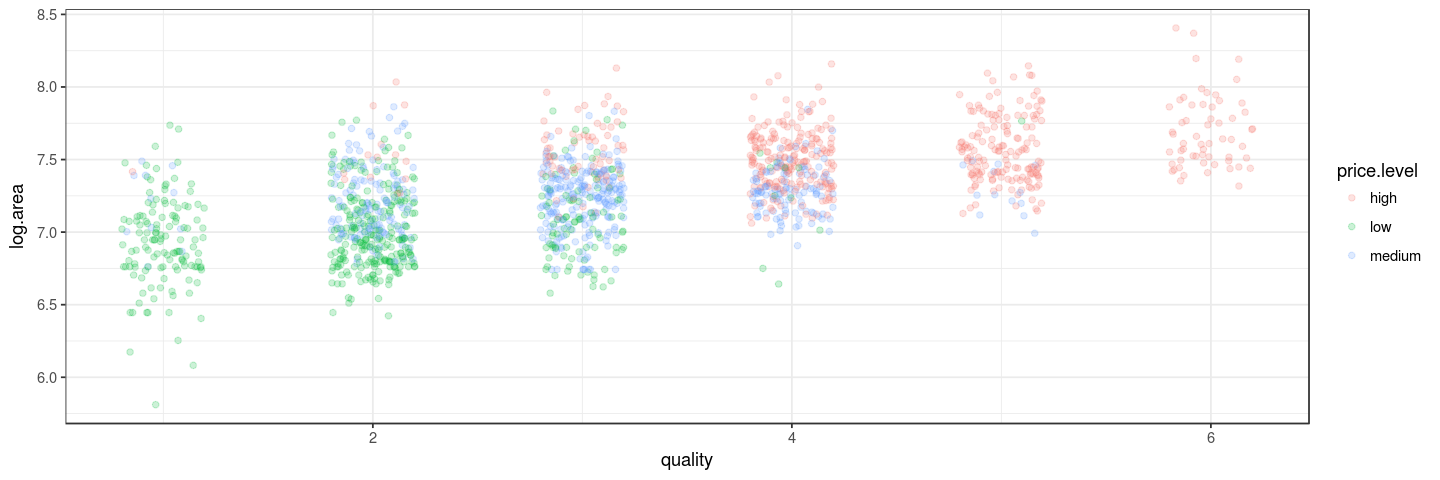

In [42]:
mod1 <- lm(log.price ~ quality + q2, data=trainset %>% mutate(q2 = quality^2)) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(log.price ~ log.area, data=trainset)
mod2 %>% glance
mod2 %>% tidy

mod3 <- lm(log.price ~ log.area + quality, data=trainset)
mod3 %>% glance
mod3 %>% tidy

trainset %>%
    mutate(
        log.area = log(GrLivArea),
        price.level = case_when(
            log.price <= quantile(log.price, 0.33) ~ 'low',
            log.price > quantile(log.price, 0.33)  & 
                log.price < quantile(log.price, 0.66) ~ 'medium',
            TRUE ~ 'high'
        )
    ) %>%
    ggplot() +
    geom_jitter(aes(x=quality, y=log.area, color=price.level), alpha=0.2, width=0.2, height=0) +
    theme_bw()

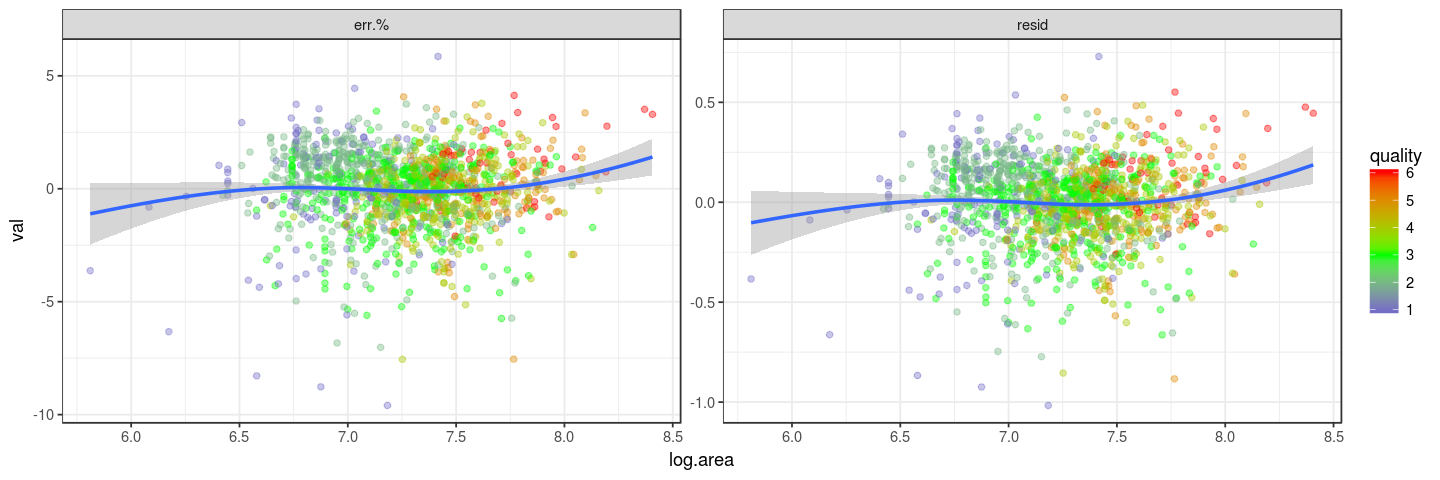

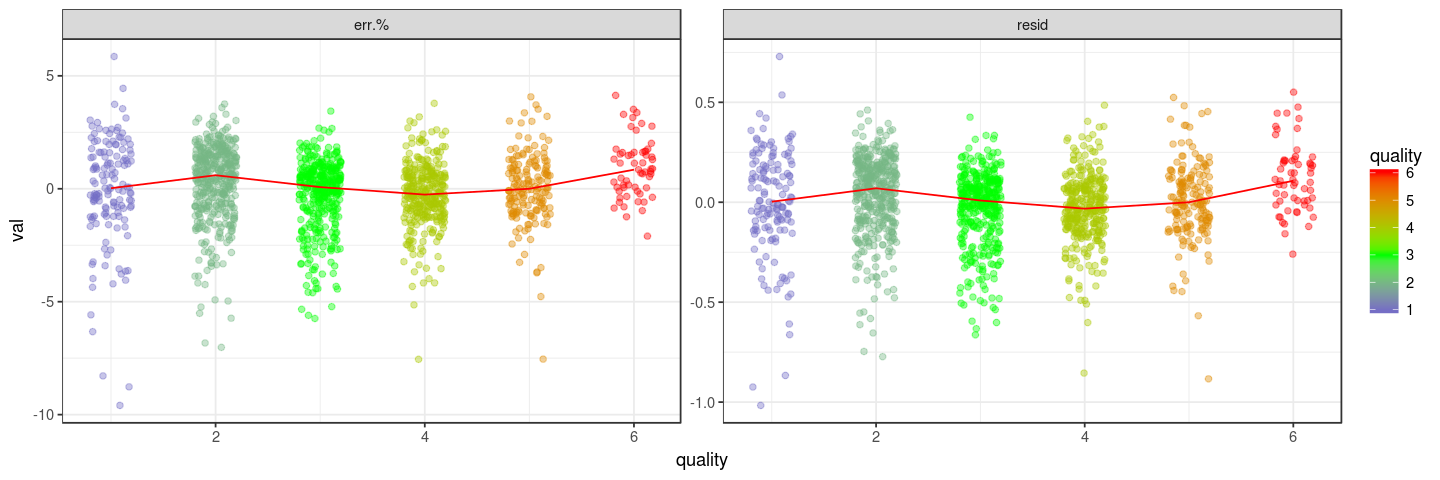

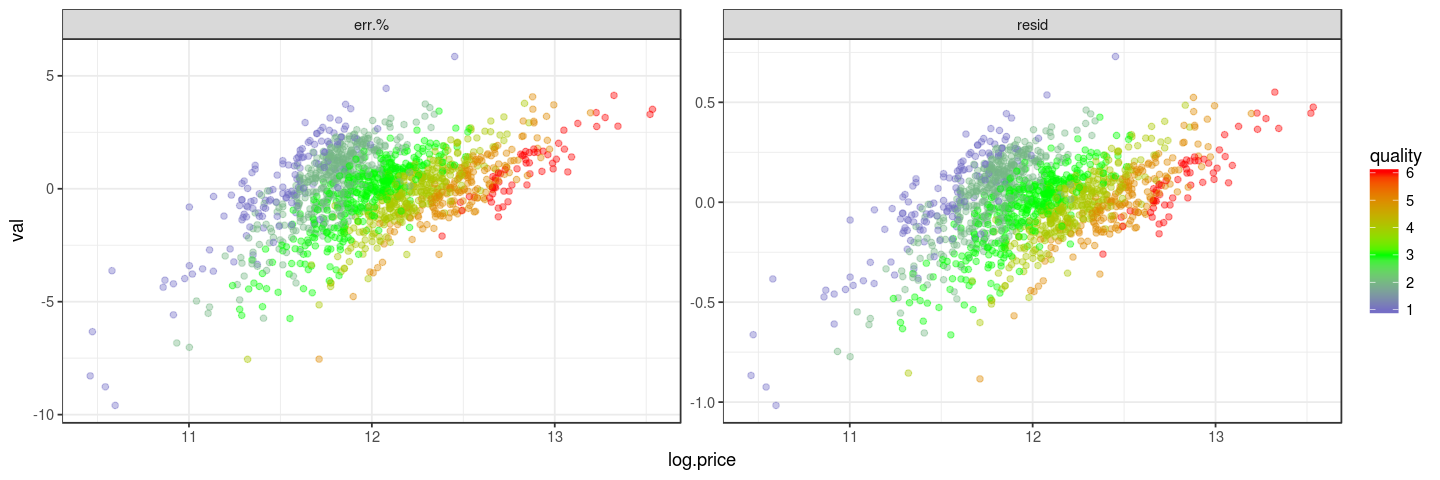

In [12]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(log.price ~ log.area + quality, data=trainset)

df <- 
    mod %>% 
    augment %>% 
    select(log.price, log.area, quality, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / log.price) %>%
    gather(name, val, -log.price, -log.area, -quality)

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=log.price, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.3446195,0.3441694,0.323703,765.6103,9.084861e-136,2,-423.2915,852.583,868.4375,152.565,1456


term,estimate,std.error,statistic,p.value
(Intercept),-3.29527359,0.5537139284,-5.95122,3.329151e-09
YearBuilt,0.00777148,0.0002808664,27.66966,9.084861e-136


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.4076478,0.4068335,0.30785,500.6544,3.564239e-166,3,-349.579,707.158,728.2973,137.8927,1455


term,estimate,std.error,statistic,p.value
(Intercept),3.862348e+02,3.131074e+01,12.33554,2.530705e-33
YearBuilt,-3.894084e-01,3.192224e-02,-12.19866,1.170740e-32
y,1.012188e-04,8.134896e-06,12.44254,7.570087e-34


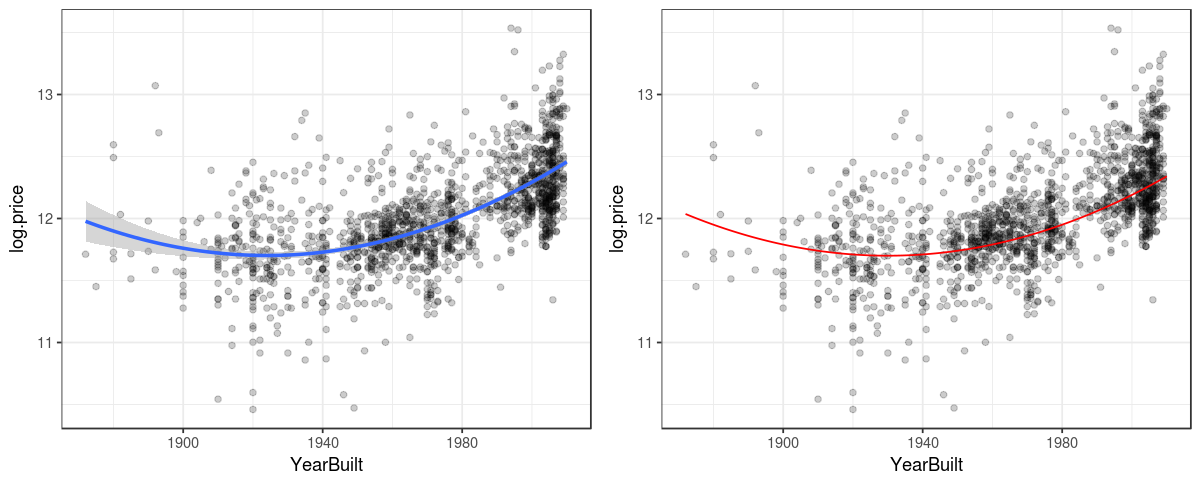

In [13]:
mod1 <- lm(log.price ~ YearBuilt, data=trainset) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(log.price ~ YearBuilt + y, data=trainset %>% mutate(y = YearBuilt*YearBuilt))
mod2 %>% glance
mod2 %>% tidy

p1 <- 
    trainset %>%
    ggplot(aes(x=YearBuilt, y=log.price)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <-
    trainset %>%
    ggplot(aes(x=YearBuilt, y=log.price)) +
    geom_point(alpha=0.2) +
    stat_function(fun = function (x) { 11.7 + 0.0001*(x - 1930)^2 }, colour = "red") +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7981759,0.7976203,0.1798185,1436.584,0,5,435.3388,-858.6775,-826.9686,46.98232,1453


term,estimate,std.error,statistic,p.value
(Intercept),-7.355761e+01,2.072396e+01,-3.549399,3.984138e-04
log.area,5.327632e-01,1.815045e-02,29.352624,4.287568e-149
quality,1.310197e-01,5.938149e-03,22.064063,2.798099e-93
year,7.971236e-02,2.117362e-02,3.764702,1.733940e-04
year2,-1.950972e-05,5.410639e-06,-3.605807,3.217093e-04


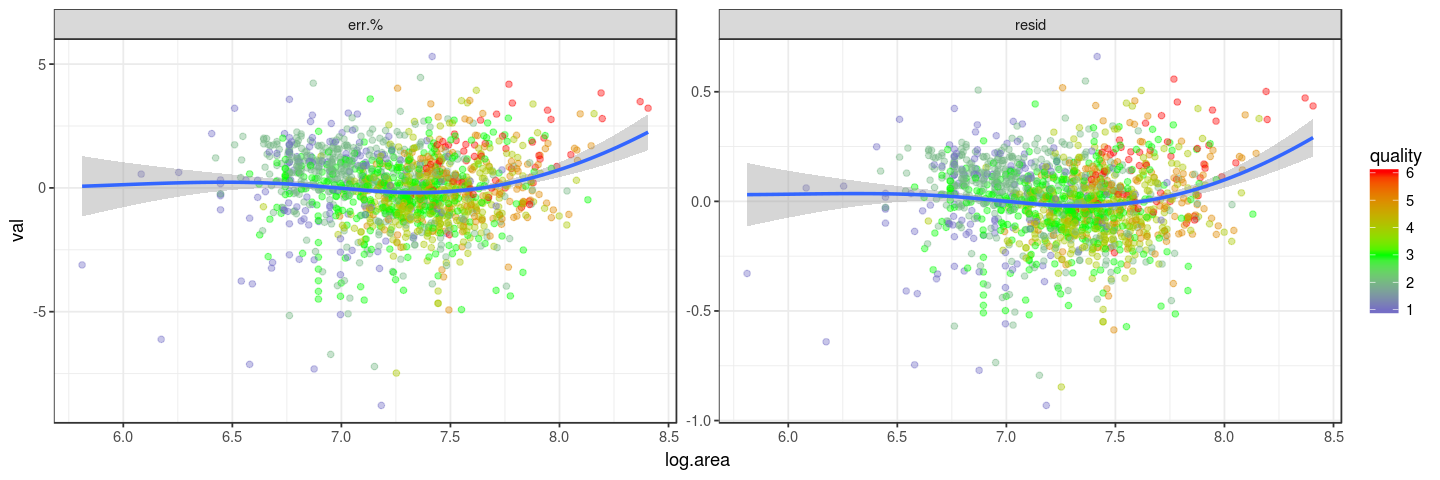

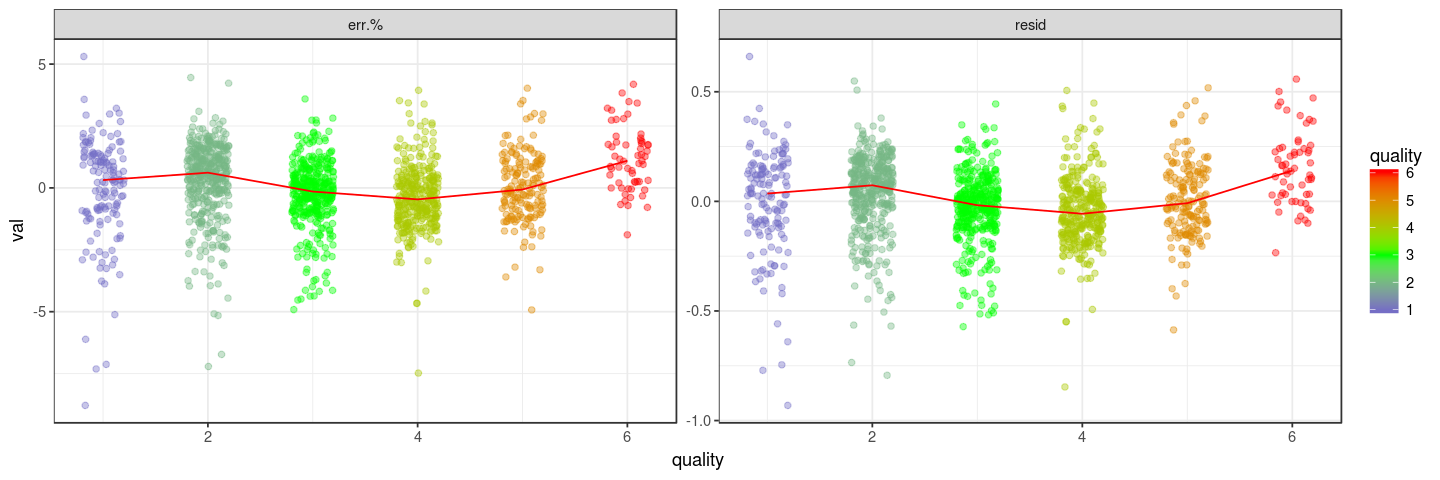

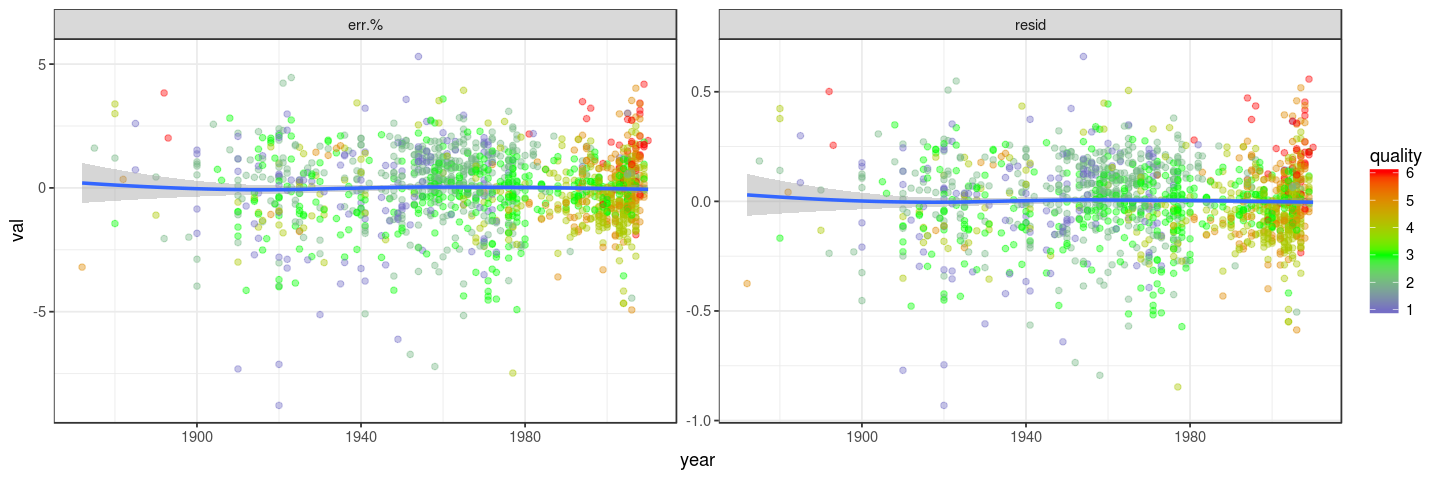

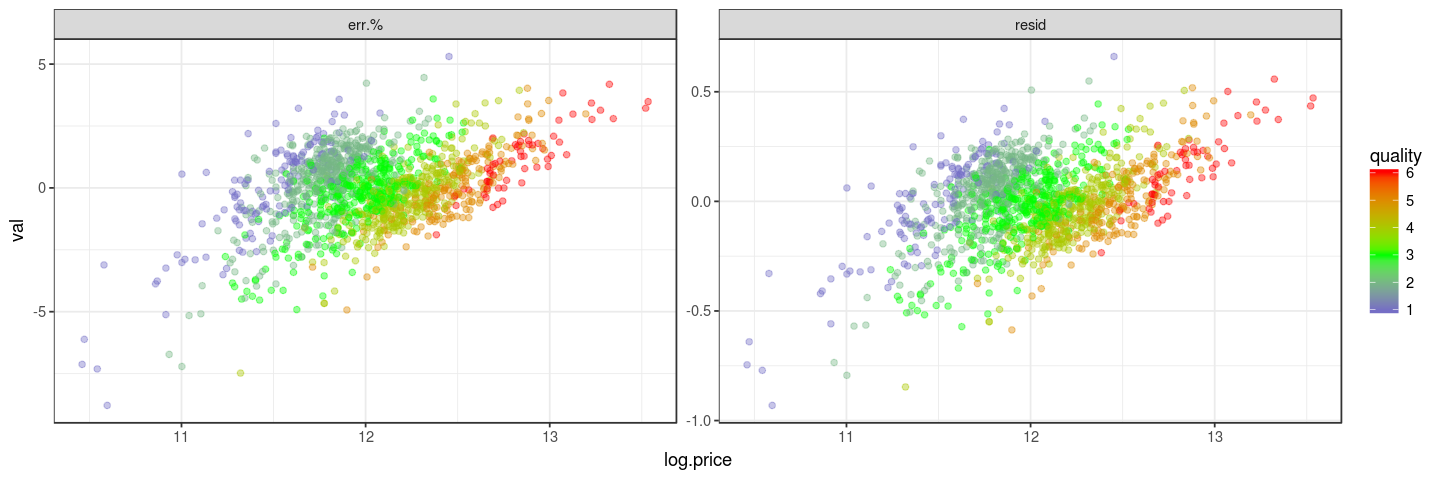

In [22]:
options(repr.plot.width = 12, repr.plot.height = 4)

df <-
    trainset %>% rename(year=YearBuilt) %>%
    mutate(year2 = year*year)

mod <- lm(log.price ~ log.area + quality + year + year2, data=df)
mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, year2, log.price, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / log.price) %>%
    gather(name, val, -log.price, -log.area, -quality, -year, -year2)


df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=log.price, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()